In [8]:
from sklearn.linear_model import LinearRegression
from matplotlib.dates import DateFormatter
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import datetime as dt
import pandas as pd
import numpy as np
import os
from numba import jit
from datetime import datetime,timedelta
import pylab

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 8
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
RESULTS_DIR_F = os.path.join(ROOT_DIR, "results_filtered")


In [9]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def prepare_topics(df,lag,threshold):

    # padding empty columns, sorting columns
    for i in range(0,30):
        if f"Topic_{i}" not in df.columns:
            df[f"Topic_{i}"] = 0
    df = df[df.columns[df.columns.str[6:].astype(float).argsort()]]

    dataframe=df

    for i in range(0,30):
        arr = df.to_numpy()
        y = arr[:,i]

        result = thresholding_algo(y, lag, threshold, influence=0)
        avg_filter = result["avgFilter"]
        threshold_filter = result["avgFilter"] + threshold * result["stdFilter"]
        signals = result["signals"]
        
        for j in range(0,len(signals)):
            if signals[j] < 1:
                signals[j] = -5
            else:
                signals[j] = y[j]

        dataframe[f"avg_filter_topic_{i}"]=avg_filter
        dataframe[f"threshold_filter_topic_{i}"]=threshold_filter
        dataframe[f"signals_topic_{i}"]=signals
        dataframe[f"y_{i}"]=y

    return dataframe
    

In [10]:
def multi_line_plot_resonance(df, title):

    topics = [f"Topic_{i}" for i in range(0,100)]
    topics = [i for i in topics if i in df.columns]
    series = [df[topic] for topic in topics]

    cm = plt.get_cmap('nipy_spectral')
    topic_count = len(series)
    cNorm  = colors.Normalize(vmin=0, vmax=topic_count-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_list = [scalarMap.to_rgba(i) for i in range(0,topic_count)]
    
    fig, ax = plt.subplots(figsize=(25, 2.5))

    ax.locator_params(axis="x", nbins=12)
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)

    for data, color, topic in zip(series, color_list, topics):
        ax.plot(data.index.values, data, color=color, linewidth=1, alpha=1, label=topic)

    ax.set(title=title, xbound=(beginning, end))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    #ax.yaxis.set_ticks([-1,0,1])
    #fig.legend(loc='center left', bbox_to_anchor=(1, 0))

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")

    return fig

In [11]:
def peaks_plot(source,df,lag,threshold,topic):

    title=f"{source} Articles - Topic {topic}"
    topic_data = prepare_topics(df,lag,threshold)

    avg_filter = topic_data[f"avg_filter_topic_{topic}"]
    threshold_filter = topic_data[f"threshold_filter_topic_{topic}"]
    signals = topic_data[f"signals_topic_{topic}"]
    y = topic_data[f"y_{topic}"]

    fig, ax = plt.subplots(figsize=(25, 2.5))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)

    ax.plot(topic_data.index.values, avg_filter, color='cyan', linewidth=1, alpha=1)
    ax.plot(topic_data.index.values, threshold_filter, color='lime', linewidth=1, alpha=1)
    ax.plot(topic_data.index.values, y, color='k', linewidth=1, alpha=1)
    ax.scatter(topic_data.index.values, signals, color='red', s=10, alpha=1)

    ax.set(title=title, xbound=(beginning, end), ylim=(0))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    #ax.yaxis.set_ticks([-1,0,1])
    #fig.legend(loc='center left', bbox_to_anchor=(1, 0))

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")

    return fig

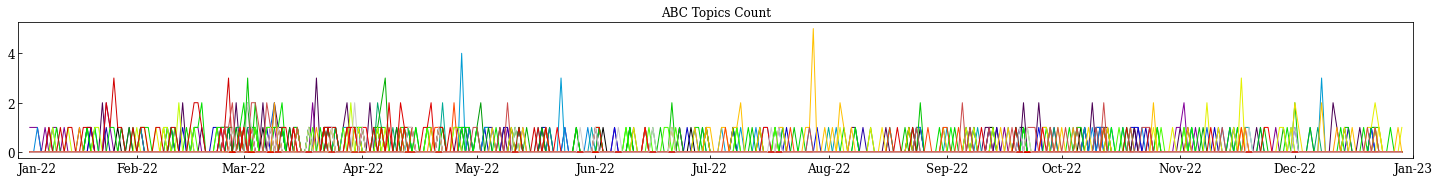

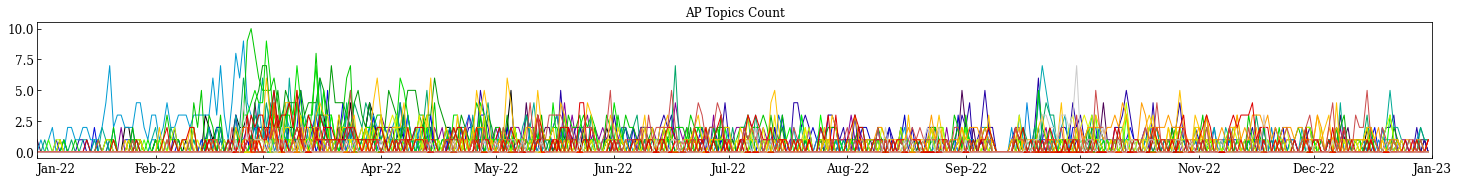

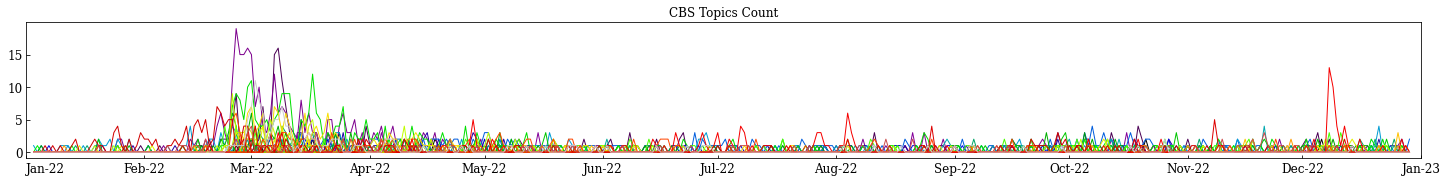

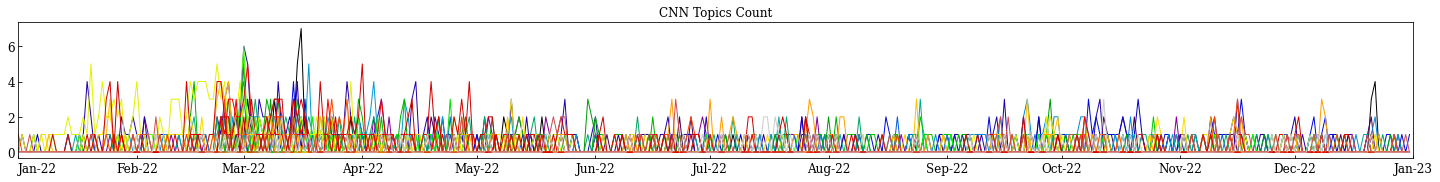

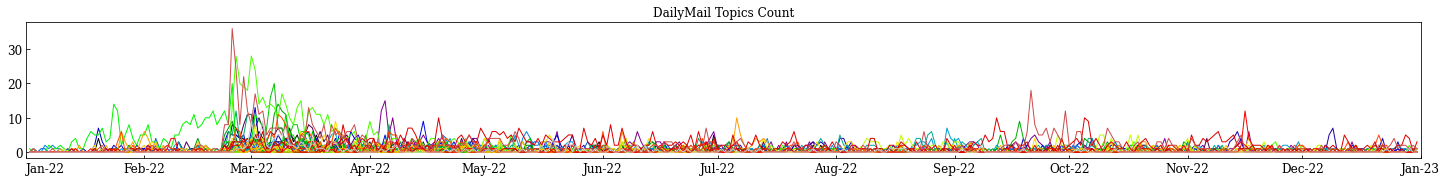

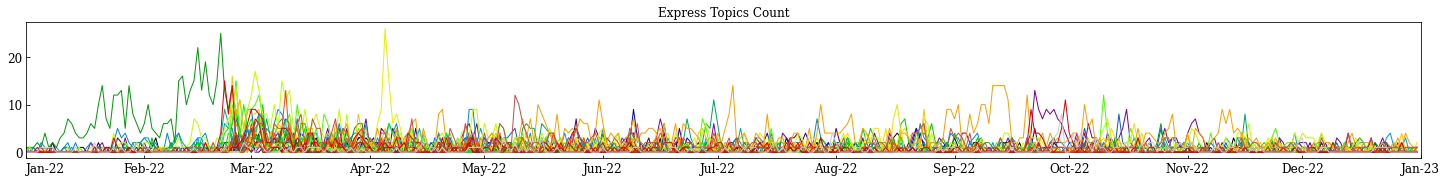

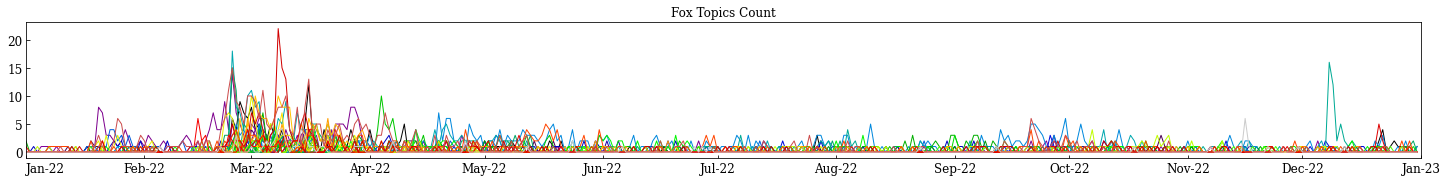

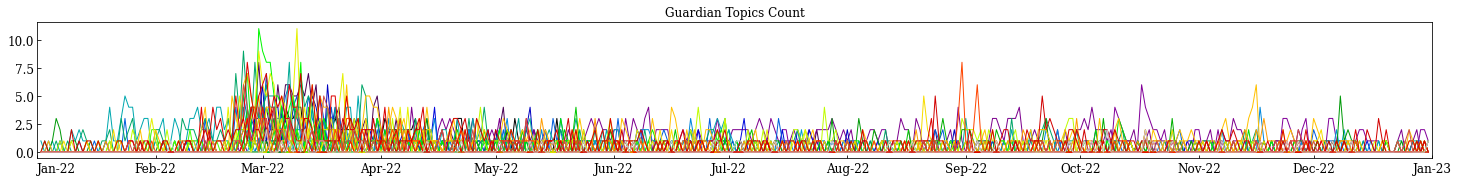

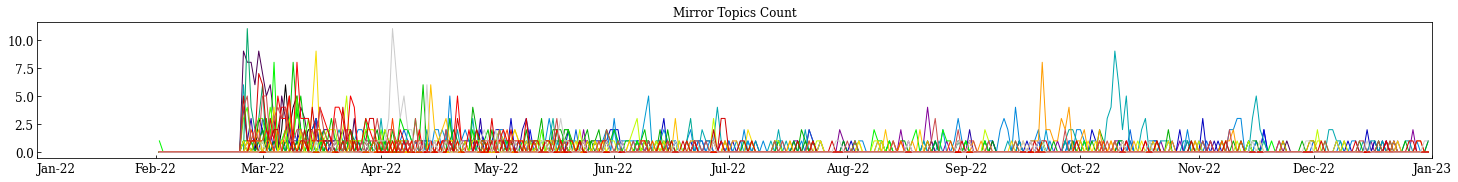

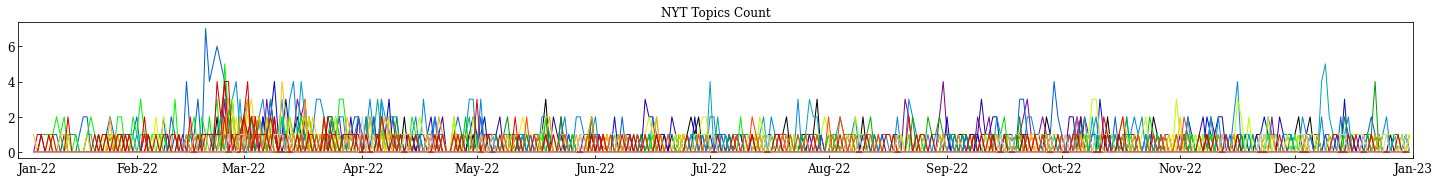

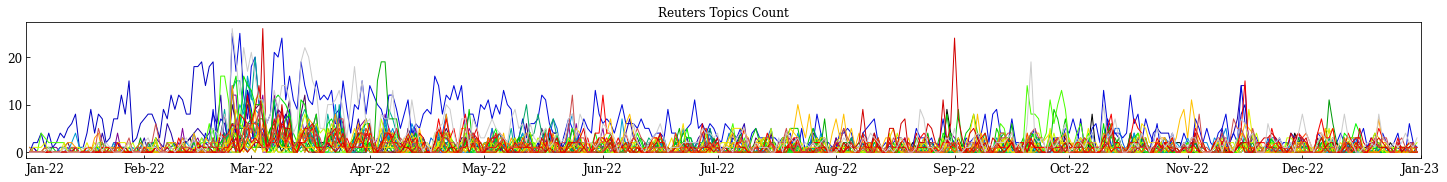

In [12]:
sources = ["ABC","AP","CBS","CNN","DailyMail","Express","Fox","Guardian", "Mirror", "NYT", "Reuters"]
data_dfs =[]
for source in sources:
    data_df = pd.read_csv(os.path.join(RESULTS_DIR, "results_5", source + "_Results.csv"), parse_dates=["Date"], index_col=["Date"])
    data_df = data_df.drop(columns=["Title", "Text", "URL","Resonance","Transience","Novelty"])
    data_df = pd.get_dummies(data_df, columns=['Topic'])
    data_df = data_df.resample("D").sum()
    data_dfs.append(data_df)

data = dict(zip(sources,data_dfs))

for source in sources:
    fig = multi_line_plot_resonance(data[source], f"{source} Topics Count")
#fig.savefig(os.path.join(ROOT_DIR, "figures","resonance_series", f"Multiline_{window}.svg"), format="svg", dpi=1000, bbox_inches="tight")


IndexError: list index out of range

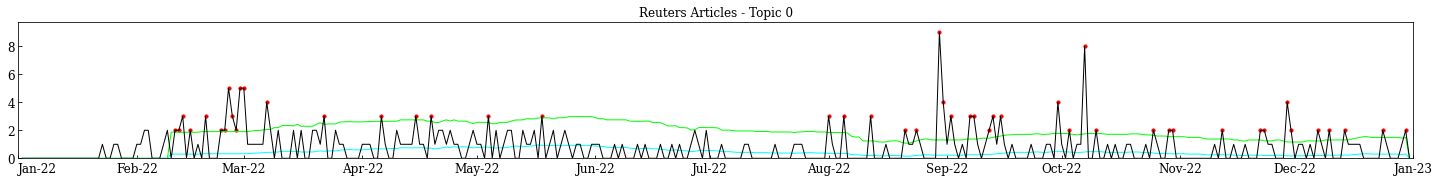

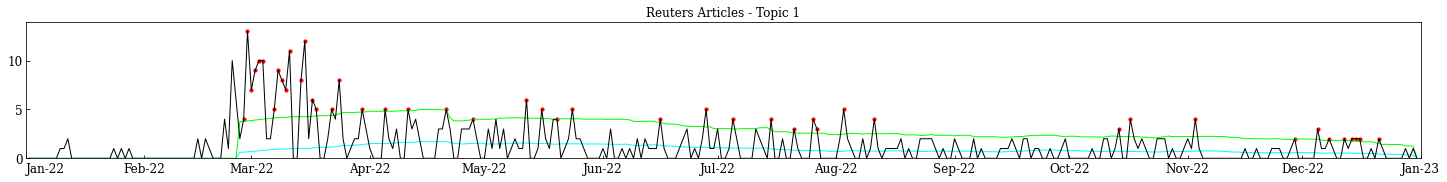

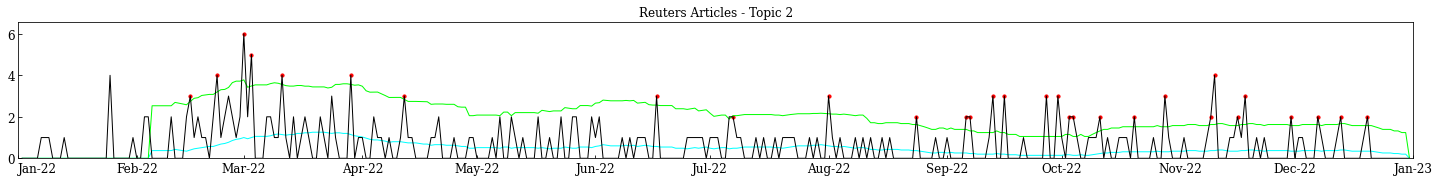

In [145]:
kwargs = {
    "Reuters":[
    {"topic":0,"lag":40,"threshold":2.6},
    {"topic":1,"lag":56,"threshold":1.9},
    {"topic":2,"lag":35,"threshold":2.6},
    # {"topic":3,"lag":50,"threshold":2},
    # {"topic":4,"lag":50,"threshold":2},
    # {"topic":5,"lag":50,"threshold":2},
    # {"topic":6,"lag":50,"threshold":2},
    # {"topic":7,"lag":50,"threshold":2},
    # {"topic":8,"lag":50,"threshold":2},
    # {"topic":9,"lag":50,"threshold":2},
    # {"topic":10,"lag":50,"threshold":2},
    # {"topic":11,"lag":50,"threshold":2},
    # {"topic":12,"lag":50,"threshold":2},
    # {"topic":13,"lag":50,"threshold":2},
    # {"topic":14,"lag":50,"threshold":2},
    # {"topic":15,"lag":50,"threshold":2},
    # {"topic":16,"lag":50,"threshold":2},
    # {"topic":17,"lag":50,"threshold":2},
    # {"topic":18,"lag":50,"threshold":2},
    # {"topic":19,"lag":50,"threshold":2},
    # {"topic":20,"lag":50,"threshold":2},
    # {"topic":21,"lag":50,"threshold":2},
    # {"topic":22,"lag":50,"threshold":2},
    # {"topic":23,"lag":50,"threshold":2},
    # {"topic":24,"lag":50,"threshold":2},
    # {"topic":25,"lag":50,"threshold":2},
    # {"topic":26,"lag":50,"threshold":2},
    # {"topic":27,"lag":50,"threshold":2},
    # {"topic":28,"lag":50,"threshold":2},
    # {"topic":29,"lag":50,"threshold":2}
    ]
}
source="Reuters"
for i in range(0,30):
    df = peaks_plot(source,data[source],**kwargs[source][i])